In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [3]:


with open('params.json') as file:
    parsed_json = json.loads(file.read())

r = requests.get('https://api.glassnode.com/v1/metrics/eth2/staking_total_validators_count', params=parsed_json['projectionParams'])

df = pd.read_json(r.text, convert_dates=['t'])
df

,t,v
0,2020-11-03,0
1,2020-11-04,363
2,2020-11-05,1015
3,2020-11-06,1253
4,2020-11-07,1371
...,...,...
690,2022-09-24,435697
691,2022-09-25,436086
692,2022-09-26,436864
693,2022-09-27,437886


In [4]:
df['day_delta']=range(len(df['t']))
df.drop('t', axis=1, inplace=True)
df

,v,day_delta
0,0,0
1,363,1
2,1015,2
3,1253,3
4,1371,4
...,...,...
690,435697,690
691,436086,691
692,436864,692
693,437886,693


In [5]:
train, test = train_test_split(df, test_size=.15)

train_predictors = train['day_delta'].to_numpy().reshape(-1, 1)
train_target = train['v']

test_predictors = test['day_delta'].to_numpy().reshape(-1, 1)
test_target = test['v']

In [6]:
lr = LinearRegression()
lr_train = lr.fit(train_predictors, train_target)
linear_train_predictions = lr_train.predict(train_predictors)

In [7]:
r2 = metrics.r2_score(train_target, linear_train_predictions)
mae = metrics.mean_absolute_error(train_target, linear_train_predictions)

print(r2)
print(mae)

0.9896632765205311
10544.596549455322


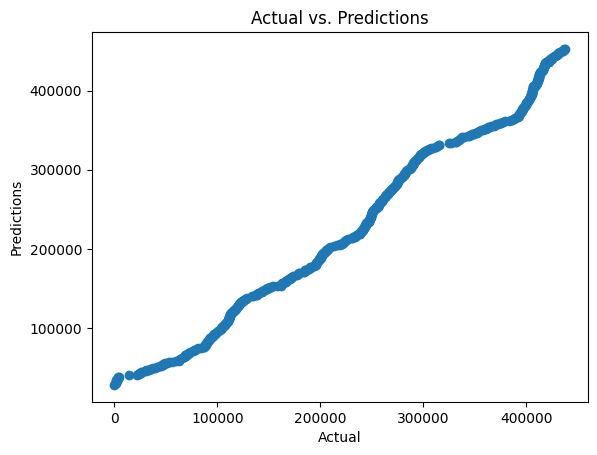

In [8]:
plt.figure()
plt.scatter(train_target, linear_train_predictions)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.title('Actual vs. Predictions')
plt.show()

In [9]:
score = lr_train.score(test_predictors, test_target)
print(score)

0.9885132555645303


In [10]:
x = df['day_delta'].to_numpy().reshape(-1, 1)
y = df['v']

total_lr = lr.fit(x, y)

In [11]:
a = float(total_lr.coef_)
b = float(total_lr.intercept_)

print(a, b)

613.8407898584239 27536.568221285183


In [12]:
projection_data = {'day_delta': range(len(df['day_delta']), len(df['day_delta'])+1095)}
projection = pd.DataFrame(projection_data)
projection['v'] = round(a*projection['day_delta']+b).astype('int')
projection['pj_issuance_yield'] = 32/np.sqrt(projection['v'])
projection

,day_delta,v,pj_issuance_yield
0,695,454156,0.047484
1,696,454770,0.047452
2,697,455384,0.047420
3,698,455997,0.047388
4,699,456611,0.047356
...,...,...,...
1090,1785,1123242,0.030193
1091,1786,1123856,0.030185
1092,1787,1124470,0.030177
1093,1788,1125084,0.030169


In [13]:
url = 'https://www.theblockcrypto.com/wp-json/v1/chart-json/ethereum-miner-revenue-daily'
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r2 = requests.get(url, headers=header).json()
r2
r2 = r2['data']['Series']['Transaction Fees']['Data']

fee_rev_df = pd.DataFrame(r2)
fee_rev_df['Date'] = pd.to_datetime(fee_rev_df['Timestamp'], unit='s')
fee_rev_df.drop('Timestamp', axis=1, inplace=True)

fee_rev_df

,Result,Date
0,320.405067,2017-01-08
1,340.138765,2017-01-09
2,359.668442,2017-01-10
3,362.688397,2017-01-11
4,349.563386,2017-01-12
...,...,...
2085,691570.544075,2022-09-24
2086,685311.925962,2022-09-25
2087,676704.674190,2022-09-26
2088,676667.523685,2022-09-27


In [14]:
r3 = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_close', params=parsed_json['projectionParams'])
price_df = pd.read_json(r3.text, convert_dates=['t'])
price_df.rename(columns={'t': 'Date', 'v':'Price'}, inplace=True)
price_df = price_df.loc[price_df['Date'] >= fee_rev_df.iloc[0 , 1] ]
price_df = price_df.loc[price_df['Date'] <= fee_rev_df.iloc[len(fee_rev_df['Date'])-1, 1]]
price_df.reset_index(inplace=True)
price_df.drop('index', axis=1, inplace=True)
price_df

,Date,Price
0,2017-01-08,10.420000
1,2017-01-09,10.380000
2,2017-01-10,10.670000
3,2017-01-11,9.970000
4,2017-01-12,9.740000
...,...,...
2085,2022-09-24,1318.137516
2086,2022-09-25,1294.082971
2087,2022-09-26,1333.477371
2088,2022-09-27,1331.183807


In [15]:
fee_rev_df['fee_rev (ETH)'] = fee_rev_df['Result']/price_df['Price']
fee_rev_df.drop('Result', axis=1, inplace=True)
fee_rev_df

,Date,fee_rev (ETH)
0,2017-01-08,30.749047
1,2017-01-09,32.768667
2,2017-01-10,33.708383
3,2017-01-11,36.377974
4,2017-01-12,35.889465
...,...,...
2085,2022-09-24,524.657356
2086,2022-09-25,529.573406
2087,2022-09-26,507.473684
2088,2022-09-27,508.320129


In [16]:
fee_rev_last_30d = fee_rev_df['fee_rev (ETH)'].tail(30)
fee_rev_last_90d = fee_rev_df['fee_rev (ETH)'].tail(90)
fee_rev_last_365d = fee_rev_df['fee_rev (ETH)'].tail(365)
fee_rev_last_1095d = fee_rev_df['fee_rev (ETH)'].tail(1095)

In [17]:
annualized_fee_rev_last30d = fee_rev_last_30d.mean()*365
annualized_fee_rev_last90d = fee_rev_last_90d.mean()*365
annualized_fee_rev_last365d = fee_rev_last_365d.mean()*365
annualized_fee_rev_last1095d = fee_rev_last_1095d.mean()*365

annualized_fee_rev = [annualized_fee_rev_last30d, annualized_fee_rev_last90d, annualized_fee_rev_last365d, annualized_fee_rev_last1095d]
annualized_fee_rev

[185515.6574702444, 199348.5084220986, 390441.02182286466, 1308199.1151863392]

In [18]:
periodos = ['30d', '90d', '365d', '1095d']
for i in range(len(periodos)):
    coluna = 'pj_fee_yield (' + periodos[i] + ')'
    projection[coluna] = annualized_fee_rev[i]/(32*projection['v'])

projection.rename(columns={'v': 'number_of_validators'}, inplace=True)
projection

,day_delta,number_of_validators,pj_issuance_yield,pj_fee_yield (30d),pj_fee_yield (90d),pj_fee_yield (365d),pj_fee_yield (1095d)
0,695,454156,0.047484,0.012765,0.013717,0.026866,0.090016
1,696,454770,0.047452,0.012748,0.013698,0.026830,0.089894
2,697,455384,0.047420,0.012731,0.013680,0.026793,0.089773
3,698,455997,0.047388,0.012714,0.013662,0.026757,0.089652
4,699,456611,0.047356,0.012697,0.013643,0.026721,0.089532
...,...,...,...,...,...,...,...
1090,1785,1123242,0.030193,0.005161,0.005546,0.010863,0.036396
1091,1786,1123856,0.030185,0.005158,0.005543,0.010857,0.036376
1092,1787,1124470,0.030177,0.005156,0.005540,0.010851,0.036356
1093,1788,1125084,0.030169,0.005153,0.005537,0.010845,0.036336


In [19]:
total_yield_projection = pd.DataFrame()
for i in range(len(periodos)):
    coluna = 'total_yield (' + periodos[i] + ')'
    coluna2 = 'pj_fee_yield (' + periodos[i] + ')'
    total_yield_projection[coluna] = projection['pj_issuance_yield'] + projection[coluna2]

total_yield_projection

,total_yield (30d),total_yield (90d),total_yield (365d),total_yield (1095d)
0,0.060249,0.061201,0.074350,0.137500
1,0.060200,0.061150,0.074282,0.137346
2,0.060151,0.061100,0.074213,0.137193
3,0.060102,0.061050,0.074145,0.137040
4,0.060053,0.060999,0.074078,0.136888
...,...,...,...,...
1090,0.035355,0.035740,0.041056,0.066589
1091,0.035344,0.035728,0.041042,0.066561
1092,0.035333,0.035717,0.041028,0.066533
1093,0.035322,0.035706,0.041014,0.066505
